In [192]:
%pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=d2ecb045b10d8e6b1db217b01eb89cb008329bfa0583b1eb52efd181b62a3745
  Stored in directory: /Users/marianaforero/Library/Caches/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [540]:
# import necessary libraries
import re, string, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)

from langdetect import detect



SEED=42

In [621]:
# cargar los datos
df_original = pd.read_csv('data/tipo1_entrenamiento_estudiantes.csv')

# Entendimiento

In [510]:
df_original.shape

(7875, 2)

In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [ ]:

df_original.sample(5)

,Review,Class
146,"Me decepcionó el hotel, las fotos q publican no reflejan la realidad. Los pasillos tienen alfombras muy viejas y sucias. El baño con el lavabo cuarteado y oxidado, una de las toallas rota. Había reservado 3 noches solo me quede 1",2
2706,"Fuimos de aniversario a cenar a ese lugar y aunque la comida es muy rica, un aplauso al cocinero. Nos tocó un tipo de mesero que jamás nos había tocado en ningún lugar. Nos entregan la cuenta y se nos hace fácil dejar el cambio al mesero. El cual al ver lo que le dejamos cambió su cara de amabilidad al despedirnos por una de desagrado. Pero no le bastó sino que no se aguanto y fue a alcanzarnos antes de salir a, en pocas palabras, exigirnos una mejor propina, a lo que dijimos que no traíamos aunque si traía, no le daría y hasta le hubiera quitado lo que le dejamos por ser tan grosero de exigirnos el servicio, si a este mesero no le pagan bien o no le convienen las propinas del lugar que se vaya a otro, o que pidan en la cuenta el servicio como en muchos lugares lo hacen. Me parece una falta de respeto haber hecho eso.",3
2645,"es un lugar de mucho movimiento, recién remodelado, todo el menú esta basado en las fajitas que son flameadas en la mesa con tequila, en verano lleva repelente parque esta a lado de la laguna - canal ... es un servicio muy rápido y siempre esta lleno.. pero para una buena cena con la familia esta perfecto.",3
3094,"el hotel es un tanto antiguo , pero en permanente proceso de refacción y trastornamiento. las áreas en común están acorde a las necesidades y Aprueba el examen. el personal que acompaña en los salones de almuerzo y cena es muy atento y servicial. destacamos la buena predisposición de la señorita Kelly .",4
4798,"Están bastante retiradas de la población. Se recomienda ir en auto o bien buscar el transporte público que te lleve. El recorrido está medianamente largo, sin dificultad, pero no son tan majestuosas como te dicen que son.",3


In [7]:
df_stats = df_original.copy()
df_stats['Word_Count'] = df_stats['Review'].apply(lambda x: len(x.split()))
df_stats

,Review,Class,Word_Count
0,"Nos alojamos en una casa alquilada en la ciudad amurallada. Parecía tan segura como cualquier otra gran ciudad con un montón de buenos restaurantes, tiendas y vida nocturna. Gran lugar para un grupo con intereses variados, no estoy seguro de que le traiga a los niños aquí sólo porque no hay mucho que hacer para ellos. Asegúrate de aventurarse fuera de la ciudad, pero algunos también es un gran lugar para alojarse",4,72
1,"La comida está bien, pero nada especial. Yo tenía mejor comida Mexcan en los Estados Unidos. Las margaritas eran geniales. El Mahi Mahi pescado recocido y seco. La carne fajitas aceptable y el coco camarones sabroso. El tortilla chips aperitivo fue decepcionante.",3,42
2,"En mi opinión, no es una como muchos usuarios reclaman. Es un gran paladar que parece ser una parada con muchos grupos de excursión. El menú es más interesante que los otros restaurantes comimos en. La parte más interesante de la experiencia es que el...edificio está en una sección de La Habana Centro. Las plantas inferiores están muy deteriorados, y tienen apartamentos donde viven muchos trabajadores de restaurante. Los pisos superiores, donde el restaurante es, han sido restauradas a gloria pasada. Las reservas son imprescindibles. Plan de 40 a 50 CUC por persona para una comida con cócteles y vinos.Más",3,100
3,"esta curiosa forma que asemeja una silla de montar de ahi su nombre es el icono de la ciudad, vale mucho la pena si no puedes ubir lo puedes asdnirr de cualquier punto de la ciudad",4,36
4,Lo mejor era la limonada. Me gusto la comida de todo el mundo y era sosa y un poco frío.,2,20
...,...,...,...
7870,"El motivo de mi estancia fue porque vine a un congreso medico, y me hospedaron en este lugar, las instalaciones están bien sin ser excelentes, la habitación bien pero tardaban casi todo el día en llegar a hacer el aseo y arreglar el cuarto, la verdad siempre quedaba un poco sucio, la regadera tenía tapado el desagüe por lo que se hacía una alberca, los alimentos buenos (rescatable el pan que acompañan con café) Lo que si es muy bueno es la gente que trabaja en el hotel, son súper amables y serviciales. Este hotel es una buena opción para su estancia además que está a 3 cuadras de paseo Montejo. Saludos desde acá 😀",3,115
7871,"Es difícil revisar el castillo porque apenas podíamos caminar por el sofocante calor, pero no creo que puedas apreciar completamente este lugar a menos que tenía un guía o eran un historiador. De lo contrario, es un gran montículo de cemento con algunos espeluznante, oscuros túneles dentro. Nada es realmente marcados o explicó excepto por una pequeña tienda de regalos y una sala de información que incluye un extraño, uniforme de viejo y sucio, montada en un soldado Mannequen sin cabeza, así que puedes llevar tu imagen. fuimos porque no hay mucho más que hacer, pero definitivamente no es la vida cambia.",3,102
7872,"Si vas a Mérida no puedes perderte de este lugar y que tiene una nueva sucursal más amplia y con la misma calidad, excelente servicio y comida deliciosa y bien servida.",5,31
7873,"Este imperdible sitio, que lleva el nombre del conquistador, es una joya urbana.Su amplitud para el tráfico local motorizado evita congestionamietos, a ambos lados una amplia zona para corredores o simples caminadores llena de pequeños cafés, restaurantes y bares para todos los gustos. Me impresionó la limpieza, la tranquilidad que en nuestros días es un privilegio y AUSENCIA DE GRAFITI. qUE HERMOSURA ES IMPERDIBLE.",5,64


In [8]:
word_count_stats = df_stats['Word_Count'].describe()
word_count_stats

count    7875.000000
mean       70.889778
std        76.289629
min         6.000000
25%        34.000000
50%        45.000000
75%        87.000000
max      2495.000000
Name: Word_Count, dtype: float64

In [ ]:
df_original.isnull().sum()

Review    0
Class     0
dtype: int64

No hay registros nulos, los datos son completos.

<Axes: xlabel='Class'>

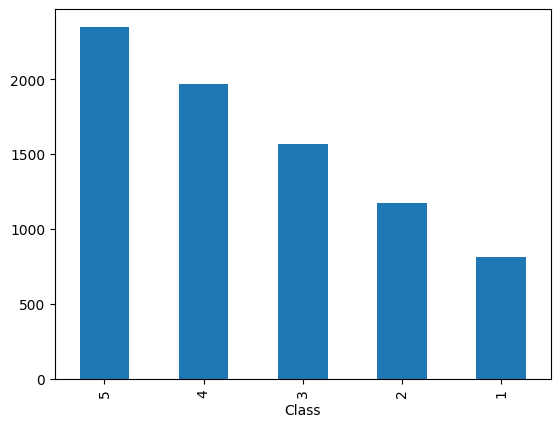

In [ ]:
# distribución de variable objetivo
df_original['Class'].value_counts().plot(kind='bar')

Todos los valores de la columna 'Class' son válidos.

In [ ]:
df_original.duplicated().sum()

71

Hay 71 registro duplicados, estos se deben eliminar del dataset.

In [ ]:
duplicated_rows = df_original[df_original.duplicated()]
duplicated_rows


,Review,Class
518,"La ubicación es muy buena, al igual que la vista, la playa contrario a lo que esperaba resultó que estaba bastante limpia.\nSe percibe el sabor y la frescura en los insumos de los alimentos , lo cual es parte de la experiencia que ofrece...el lugar ya que tienen sus propias granjas productoras. La carta es limitada ( lo cual en mi caso prefiero, ya que se nota el esmero en cada uno de los platos que preparan), los precios están por arriba del promedio de otros restaurantes cercanos pero no llegan a ser exagerados, desconozco si eso se debió a que solo se tenía un salón disponible, ya que en la fecha que lo visité, el resto del restaurante se encontraba en remodelación (es la único razón por lo cual no otorgo la evaluación más alta), mi sugerencia sería que siguieran manteniendo los precios ya que los hace muy competitivos … sin duda regresaría, es un lugar que debes visitar en Veracruz sobre todo si eres fanático del buen comer…Más",4
1112,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
1605,"Cierran a las 3 pm, cobraron $85 adultos y niños (por lo menos los de 2 años) y adulto mayor gratis. A la entrada hay guías. Se juntan grupos de mínimo 10 personas y te cobran $70 por persona o $700 a quien se los pague. Excelente explicación y atención de parte de ellos. Poca claridad de información en redes, y el número telefónico no sirve. Llegamos fácilmente con waze. Lleven buen bloqueador, sombrero y de preferencia tenis.",3
1843,"Acudimos un sábado 2 de julio a las 11:15 de la mañana. Estuvimos esperando más de media hora nosotros dos y otro grupo de cuatro personas fuera, porque la camarera estaba dentro. Nos vio como estábamos esperando y no fue capaz de salir a atendernos...o dar alguna explicación si el bar estaba abierto o cerrado.\n\nNos tuvimos que marcharMás",1
1851,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
...,...,...
7520,"Un lugar muy limpio ordenado hermoso con áreas amplias que vale la pena disfrutar en familia un momento, primera vez que lo visito pero vale la pena acudir.",3
7601,"El lugar es una maravilla que merece ser visitado. El servicio de cobro es pésimo y no es por el dinero porque mucha gente entra gratis, se hacen filas de más de 1 hora para pasar a pleno sol y mucha gente se mete disque al baño y no hace fila. Esta muy desorganizado.",2
7756,Deben de actualizar los horarios en las diferentes páginas ya que como yo o cualquiera de los visitantes que vamos podemos llegar y encontrar cerrado y luego la página para buscar información no funciona.,3
7794,"Wow Había escuchado muchas recomendaciones de este lugar, pero nunca había ido, hace unos fui y me precio muy interesante toda las historias que hay en este museo.",5


# Procesamiento y Preparación

In [ ]:
# eliminar las filas duplicadas
df_prep = df_original.drop_duplicates()

In [ ]:
df_prep.shape

(7804, 2)

In [624]:
# elimnar filas con texto en otros idiomas
def detect_language(text):
    try:
        language = detect(text)
        return language == 'es'  # Check if language is Spanish
    except:
        return False

In [625]:
df_prep = df_prep[df_prep['Review'].apply(detect_language)]
df_prep.shape

(7798, 2)

In [16]:
# elimnar filas con texto en otros idiomas
def detect_language(text):
    try:
        language = detect(text)
        return language == 'es'  # Check if language is Spanish
    except:
        return False

In [17]:
df_prep = df_prep[df_prep['Review'].apply(detect_language)]

In [18]:
df_prep.shape

(7798, 2)

In [19]:
# TODO: guardar datos despues de transformaciones de limpieza
# df_prep.to_csv('data/tipo1_entrenamiento_estudiantes_prep.csv', index=False)

## Divisón en entrenamiento y prueba 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_prep["Review"], df_prep["Class"], test_size = 0.3, stratify = df_prep["Class"], random_state = SEED)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6243,), (1561,), (6243,), (1561,))

## Tokenización / Vectorización

"Feature engineering"

* Bag of Words / Count Tokenizer
* Tf-IDF

In [ ]:
# Descargar los datos necesarios
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('spanish'))

In [17]:
def tokenize_text(text):
    # convertir a minúsculas
    text = text.lower()

    # eliminar caracteres numericos
    text = re.sub(r'\d+', '', text)

    # eliminar puntuación
    text = text.translate(str.maketrans('', '', string.punctuation))

    # eliminar caracters especiales
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"
                            u"\U0001F300-\U0001F5FF"
                            "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') 

    tokens = word_tokenize(text)

    # eliminar las stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # eliminar los stems de las palabras
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [ ]:
bow_vectorizer = CountVectorizer(tokenizer=tokenize_text)
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_text)

In [ ]:
X_train_bow = bow_vectorizer.fit_transform(X_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eram', 'estab', 'estais', 'estan', 'estareis', 'estari', 'estariais', 'esteis', 'esten', 'estes', 'estuvier', 'estuvies', 'fuer', 'fues', 'habeis', 'habi', 'habiais', 'habr', 'habreis', 'habri', 'habriais', 'hayais', 'hubier', 'hubies', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'ser', 'sereis', 'seri', 'seriais', 'si', 'tambi', 'tendr', 'tendreis', 'tendri', 'tendriais', 'teneis', 'tengais', 'teni', 'teniais', 'tuvier', 'tuvies'] not in stop_words.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_

In [ ]:
len(bow_vectorizer.vocabulary_)

12583

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
len(tfidf_vectorizer.vocabulary_)

12583

In [524]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaaa,aaaah,ab,abad,abaj,abajol,...,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb,zur
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaaa,aaaah,ab,abad,abaj,abajol,...,zonassi,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5455,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_bow_sklearn = pd.DataFrame(X_train_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())
df_bow_sklearn

,...,......,8,aa,aaaaa,aaaah,ab,abad,abaj,abajol,...,zonassi,zoo,zoofari,zoolog,zorr,zotan,zuegly,zul,zum,zumb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Eliminación de palabras con baja frecuencia

In [24]:
#FRECUENCIA DE PALABRAS

# Obtener el vocabulario
vocabulario = bow_vectorizer.vocabulary_
# Obtener la suma de las frecuencias de cada palabra en todo el conjunto de datos
frecuencia_total = X_train_bow.sum(axis=0)
# Crear un diccionario que mapea cada palabra a su frecuencia total
frecuencias = {palabra: frecuencia_total[0, indice] for palabra, indice in vocabulario.items()}

# Convertir el diccionario de frecuencias en un DataFrame
df_frecuencias = pd.DataFrame(list(frecuencias.items()), columns=['Palabra', 'Frecuencia'])

# Ordenar el DataFrame por frecuencia de forma descendente
df_frecuencias = df_frecuencias.sort_values(by='Frecuencia', ascending=False)
# Imprimir las frecuencias de cada palabra
df_frecuencias

,Palabra,Frecuencia
86,hotel,3236
118,buen,2831
313,com,2369
97,habit,2360
116,mas,2114
...,...,...
8407,lucidor,1
8406,blamang,1
8405,ofrend,1
8404,excelentevolveri,1


In [25]:
df_palabras_altafrec = df_frecuencias[df_frecuencias['Frecuencia'] > 50]
df_palabras_altafrec.describe()

,Frecuencia
count,778.000000
mean,216.021851
std,294.307561
min,51.000000
25%,74.250000
50%,119.000000
75%,245.500000
max,3236.000000


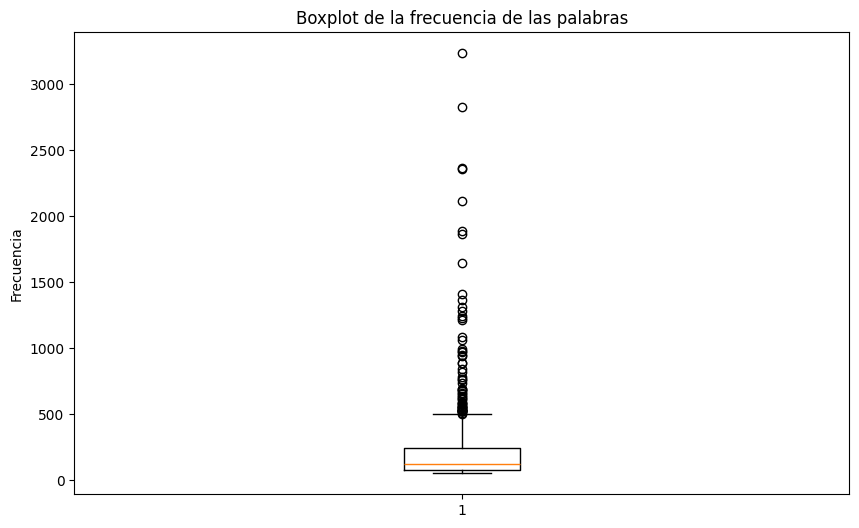

In [26]:
#Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(df_palabras_altafrec['Frecuencia'])
plt.title('Boxplot de la frecuencia de las palabras')
plt.ylabel('Frecuencia')
plt.show()

In [27]:
# Obtener las palabras de alta frecuencia como una lista
palabras_altafrecuencia = df_palabras_altafrec['Palabra'].tolist()

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_bow_sklearn_filtrado = df_bow_sklearn[palabras_altafrecuencia]

len(df_bow_sklearn_filtrado.columns)

778

In [28]:
# Convertir el DataFrame de nuevo a un array de NumPy
X_train_bow_filtrado = df_bow_sklearn_filtrado.to_numpy()
X_train_bow_filtrado.shape

(6243, 778)

# Entrenamiento y evaluación de modelos

## Random Forest

Desarrollado por: Andrés Arévalo

El algoritmo Random Forest es un método de aprendizaje automático basado en árboles de decisión que se utiliza tanto para tareas de clasificación como de regresión. En el contexto del análisis de texto, Random Forest utiliza una técnica de conjunto (ensemble) donde se construyen múltiples árboles de decisión, cada uno entrenado con una muestra aleatoria de las características y registros disponibles. Para el análisis de texto, los árboles de decisión en Random Forest evalúan las palabras presentes en cada reseña para determinar la clasificación. A medida que cada árbol realiza su propia predicción, la clasificación final se determina por votación mayoritaria entre todos los árboles en el bosque. Esto significa que cada árbol contribuye con su propia opinión sobre la clasificación de una reseña, y la decisión final se toma en base a la opinión colectiva del conjunto de árboles.

In [29]:
X_test_bow = bow_vectorizer.transform(X_test)

In [30]:
# Convertir la matriz dispersa X_test_bow a un DataFrame
df_X_test_bow = pd.DataFrame(X_test_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())

# Filtrar las columnas que coinciden con las palabras de alta frecuencia
df_X_test_bow_filtrado = df_X_test_bow[palabras_altafrecuencia]
print(len(df_X_test_bow_filtrado.columns))
# Convertir el DataFrame de nuevo a un array de NumPy
X_test_bow_filtrado = df_X_test_bow_filtrado.to_numpy()


778


### Random Forest: Sin frecuencias y 250 estimadores

#### Entrenamiento

In [31]:
# Crear el clasificador de Random Forest
random_forest_1 = RandomForestClassifier(n_estimators=250, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_1.fit(X_train_bow, y_train)

RandomForestClassifier(n_estimators=250, random_state=42)

#### Evaluación

In [32]:
#Metricas
y_pred_train = random_forest_1.predict(X_train_bow)
y_pred_test = random_forest_1.predict(X_test_bow)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 1.0
Precisión en prueba: 0.4436416140868148
Recall en entrenamiento: 1.0
Recall en prueba: 0.4561178731582319
F1 en entrenamiento: 1.0
F1 en prueba: 0.42715182693506737


### Random Forest: Umbral frecuencias palabras y 150 estimadores

#### Entrenamiento

In [33]:
# Crear el clasificador de Random Forest
random_forest_2 = RandomForestClassifier(n_estimators=150, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_2.fit(X_train_bow_filtrado, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

#### Evaluación

In [34]:
#Metricas
y_pred_train = random_forest_2.predict(X_train_bow_filtrado)
y_pred_test = random_forest_2.predict(X_test_bow_filtrado)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 1.0
Precisión en prueba: 0.43824363160291985
Recall en entrenamiento: 1.0
Recall en prueba: 0.4497117232543241
F1 en entrenamiento: 1.0
F1 en prueba: 0.4337937056521637


### Random Forest: Umbral frecuencias palabras, 250 estimadores, Max Depth 30

#### Entrenamiento

In [35]:
# Crear el clasificador de Random Forest
random_forest_3 = RandomForestClassifier(n_estimators=250, max_depth=30, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_3.fit(X_train_bow_filtrado, y_train)

RandomForestClassifier(max_depth=30, n_estimators=250, random_state=42)

#### Evaluación

In [36]:
#Metricas
y_pred_train = random_forest_3.predict(X_train_bow_filtrado)
y_pred_test = random_forest_3.predict(X_test_bow_filtrado)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 0.9105185548735883
Precisión en prueba: 0.42333577420881147
Recall en entrenamiento: 0.8926798013775429
Recall en prueba: 0.438821268417681
F1 en entrenamiento: 0.8943910823438154
F1 en prueba: 0.4065870266257479


### Random Forest: Umbral frecuencias palabras y 250 estimadores

#### Entrenamiento

In [37]:
# Crear el clasificador de Random Forest
random_forest_4 = RandomForestClassifier(n_estimators=250, random_state=42)

# Entrenar el modelo utilizando X_train_bow como matriz de características y y_train como vector de etiquetas
random_forest_4.fit(X_train_bow_filtrado, y_train)

RandomForestClassifier(n_estimators=250, random_state=42)

#### Evaluación

In [38]:
#Metricas
y_pred_train = random_forest_4.predict(X_train_bow_filtrado)
y_pred_test = random_forest_4.predict(X_test_bow_filtrado)

precision_train = precision_score(y_train, y_pred_train, average='weighted')
precision_test = precision_score(y_test, y_pred_test, average='weighted')

recall_train = recall_score(y_train, y_pred_train, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')

f1_train = f1_score(y_train, y_pred_train, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

print('Precisión en entrenamiento:', precision_train)
print('Precisión en prueba:', precision_test)

print('Recall en entrenamiento:', recall_train)
print('Recall en prueba:', recall_test)

print('F1 en entrenamiento:', f1_train)
print('F1 en prueba:', f1_test)

Precisión en entrenamiento: 1.0
Precisión en prueba: 0.44436526403334653
Recall en entrenamiento: 1.0
Recall en prueba: 0.4548366431774504
F1 en entrenamiento: 1.0
F1 en prueba: 0.4383480411996237


### Reporte de métricas Mejor Modelo Random Forest 

In [39]:
from sklearn.metrics import classification_report

y_pred = random_forest_4.predict(X_test_bow_filtrado)
# Obtener el informe de clasificación
report = classification_report(y_test, y_pred)

# Imprimir el informe de clasificación
print(report)


              precision    recall  f1-score   support

           1       0.53      0.25      0.34       158
           2       0.38      0.34      0.36       232
           3       0.38      0.30      0.33       310
           4       0.39      0.39      0.39       393
           5       0.54      0.75      0.63       468

    accuracy                           0.45      1561
   macro avg       0.44      0.40      0.41      1561
weighted avg       0.44      0.45      0.44      1561



### Análisis de Resultados Mejor Modelo Random Forest : Entendimiento de palabras con mayor importancia por clase. 

In [40]:
# Obtener la importancia de las variables
importances = random_forest_4.feature_importances_

# Obtener los nombres de las variables
feature_names = np.array(df_bow_sklearn_filtrado.columns)

# Crear un diccionario con la importancia de cada variable
feature_importance_dict = dict(zip(feature_names, importances))

# Ordenar las variables por su importancia
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Crear una lista para almacenar las variables más relevantes
top_features = []

# Imprimir las variables ordenadas por su importancia y guardar las más relevantes en la lista
for feature, importance in sorted_feature_importance:
    if importance > 0.004:
        print(f"{feature}: {importance}")
        top_features.append((feature, importance))

# Convertir la lista de tuplas en una nueva tupla
top_features_tuple = tuple(top_features)

# Verificar las variables más relevantes guardadas en la nueva tupla
print("Top features:", top_features_tuple)

excelent: 0.013847523329354664
mal: 0.013807121406355854
buen: 0.009767358804765439
habit: 0.008254145012191325
hotel: 0.007548745939129834
lug: 0.006774000968154763
mas: 0.0066776238106899454
com: 0.006631979083615405
pesim: 0.006544804208531
si: 0.005672693369727765
servici: 0.005531179162717607
bien: 0.005304308760942602
recomend: 0.00519168013907594
mejor: 0.005184304968774137
suci: 0.005145544657259741
sol: 0.005051547202132716
visit: 0.004985055244091132
peor: 0.004857506774571444
pued: 0.004824944588934375
restaur: 0.004543962628907699
habi: 0.004436478777472449
hac: 0.004373563571986233
vist: 0.0043177849176939224
ciud: 0.00427425460201152
haban: 0.00426795625390923
atencion: 0.004227667117927382
lleg: 0.004223217970796804
Top features: (('excelent', 0.013847523329354664), ('mal', 0.013807121406355854), ('buen', 0.009767358804765439), ('habit', 0.008254145012191325), ('hotel', 0.007548745939129834), ('lug', 0.006774000968154763), ('mas', 0.0066776238106899454), ('com', 0.006631

In [42]:
import pandas as pd

# Crear un DataFrame para y_train con el nombre de la columna 'class'
df_y_train = pd.DataFrame({'class': y_train})

# Resetear los índices de df_y_train
df_y_train.reset_index(drop=True, inplace=True)

# Crear un DataFrame para X_train_bow con las palabras de alta frecuencia como columnas
df_X_train_bow = pd.DataFrame(data=X_train_bow_filtrado, columns=palabras_altafrecuencia)

# Concatenar los dos DataFrames a lo largo de las columnas (axis=1)
df_results = pd.concat([df_X_train_bow, df_y_train], axis=1)

# Verificar el DataFrame resultante
print(df_results)



      hotel  buen  com  habit  mas  si  lug  servici  bien  pued  ...  obvi  ingres  cont  exposicion  sop  fabul  huel  adicional  respect  class
0         0     0    0      0    0   0    0        0     0     0  ...     0       0     0           0    0      0     0          0        0      5
1         0     0    0      0    0   0    0        0     0     0  ...     0       0     0           0    0      0     0          0        0      3
2         0     0    0      0    0   0    0        1     0     0  ...     0       0     0           0    0      0     0          0        0      5
3         0     0    0      0    0   0    1        0     0     0  ...     0       0     0           0    0      0     0          0        0      5
4         2     1    0      1    1   0    0        0     1     0  ...     1       0     0           0    0      0     0          0        0      3
...     ...   ...  ...    ...  ...  ..  ...      ...   ...   ...  ...   ...     ...   ...         ...  ...    ...   ..

In [43]:
# Agrupar por clase y sumar las ocurrencias de cada palabra
word_counts_by_class = df_results.groupby('class').sum()
word_counts_by_class

# Crear un DataFrame solo con las top features
df_top_features = word_counts_by_class[list(dict(top_features).keys())]

# Verificar el DataFrame resultante
print(df_top_features)

       excelent  mal  buen  habit  hotel  lug  mas  com  pesim   si  ...  peor  pued  restaur  habi  hac  vist  ciud  haban  atencion  lleg
class                                                                ...                                                                   
1            11  258   149    381    529  161  246  262    105  233  ...    82    95      122   199  164    51    37     77        72   187
2            48  346   374    657    767  245  417  388     51  344  ...    56   220      188   218  238   129    86    143        90   235
3           116  181   631    584    757  365  542  464     26  487  ...    26   262      261   204  288   220   158    249       117   204
4           276   61   971    442    651  533  449  558      3  460  ...     6   400      332   125  270   293   297    280       124   141
5           611   40   706    296    532  561  460  697      2  367  ...     3   389      407    93  280   297   308    231       290   172

[5 rows x 27 column

In [44]:
# Iterar sobre las clases
for class_label in df_top_features.index:
    # Obtener las palabras con una frecuencia mayor o igual a 100 para la clase actual
    top_words = df_top_features.loc[class_label][df_top_features.loc[class_label] >= 100].sort_values(ascending=False)
    # Imprimir las palabras y sus frecuencias para la clase actual
    print(f"Clase {class_label}:")
    print(top_words)
    print("-----------------------")

Clase 1:
hotel      529
habit      381
com        262
mal        258
mas        246
si         233
habi       199
servici    192
lleg       187
hac        164
lug        161
sol        159
buen       149
restaur    122
mejor      111
suci       109
pesim      105
bien       102
Name: 1, dtype: int64
-----------------------
Clase 2:
hotel      767
habit      657
mas        417
com        388
buen       374
mal        346
si         344
servici    288
sol        267
lug        245
mejor      243
hac        238
lleg       235
pued       220
habi       218
bien       215
restaur    188
haban      143
vist       129
visit      120
suci       106
Name: 2, dtype: int64
-----------------------
Clase 3:
hotel       757
buen        631
habit       584
mas         542
si          487
com         464
lug         365
bien        347
sol         322
mejor       308
servici     296
hac         288
pued        262
restaur     261
visit       255
haban       249
vist        220
lleg        204
habi    

## Regresion Logistica

Desarrollado por: Mariana Forero

### Bag of words

In [636]:
# Train the logistic regression model
bow_model = LogisticRegression(multi_class='multinomial', max_iter=1000)  # Increase max_iter for convergence
bow_model.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [637]:
x_test_bow=bow_vectorizer.transform(X_test)

In [638]:
y_pred_bow = bow_model.predict(x_test_bow)
y_predT_bow=bow_model.predict(X_train_bow)

#### Analisis Cuantitativo

In [639]:
# Calculo Precision
accuracy = accuracy_score(y_test, y_pred_bow)
print("Accuracy:", accuracy)

Accuracy: 0.45427350427350427


In [640]:
# Calculate accuracy
accuracy = accuracy_score(y_train, y_predT_bow)
print("Accuracy:", accuracy)

Accuracy: 0.9785635764016123


La precision del modelo utilizando los datos de train es mucho mayor a la presicion  obtenida con los datos de test por lo que el modelo podria tener overfitting. 

In [641]:
# Other metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bow))


Classification Report:
              precision    recall  f1-score   support

           1       0.49      0.42      0.46       236
           2       0.36      0.32      0.34       348
           3       0.34      0.32      0.33       465
           4       0.40      0.42      0.41       589
           5       0.59      0.65      0.62       702

    accuracy                           0.45      2340
   macro avg       0.44      0.43      0.43      2340
weighted avg       0.45      0.45      0.45      2340



In [642]:
print("F1:", f1_score(y_test, y_pred_bow, average='micro'))

F1: 0.45427350427350427


El F1 es bajo pero esto se debe a la naturaleza multinomial de la regresion utilizada. 

In [643]:
bow_feature_names = bow_vectorizer.get_feature_names_out()
bow_coefficients = bow_model.coef_

In [644]:
# Print most influential words for each score
for i, score in enumerate(range(1, 6)):  # Scores range from 1 to 5
    print(f"Score {score}:")
    score_coefficients = bow_coefficients[i]
    sorted_indices = np.argsort(score_coefficients)
    top_words = [bow_feature_names[idx] for idx in sorted_indices[-10:]]  # Get top 10 words
    top_words.reverse()  # Reverse to get words with highest coefficients first
    print(top_words)

Score 1:
['pesim', 'peor', 'terribl', 'suci', 'horribl', 'cobr', 'grit', 'duch', 'emple', 'acuerd']
Score 2:
['decepcion', 'neg', 'desorganiz', 'agres', 'coctel', 'carril', 'mal', 'hamburgues', 'nadi', 'ventan']
Score 3:
['lent', 'canal', 'seis', 'febrer', 'trayect', 'mayor', 'infest', 'asist', 'normal', 'mencion']
Score 4:
['grat', 'figur', 'city', 'carec', 'reflej', 'den', 'arracher', 'conoci', 'dign', 'tunel']
Score 5:
['delici', 'excelent', 'padr', 'increibl', 'ampli', 'quer', 'recomend', 'acced', 'toqu', 'galeri']


Las palabras obtenidas para describir cada score tienen sentido ya describen lo que se esperaria de una review con ese puntaje. Por ejemplo para las puntuaciones mas bajas las palabras en general son cosas negativas como pesimo, terrible, sucio, mal, desorganizado, por mencionar algunas. Y para las puntuaciones mas altas las palabras son positivas como padre, increible, recomendado, excelente, entre otras. Aunque para el 4 hay palabras que no se asociarian normalmente a esa puntuacion pero puede ser que por los datos estudiados el modelo las haya asignado asi.

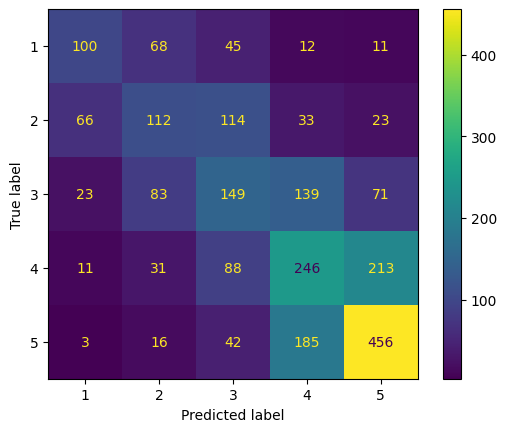

In [645]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bow)

La matriz de confusion mustras buenos resultados ya que en la diagonal hay una buena concentracion de casos de modod que el modelo esta clasificando buen la mayoria de las reviews, ademas aunque los casos cerca de la diagonal sean equivocados igual estan cerca del puntaje  correcto, por lo que no seria un error tan significativo como los pocos casos en los que ya hay un salt mayor entre el error clasificando una review negativa como positiva y viceversa. 

### Tf-IDF

In [646]:
# Train the logistic regression model
model = LogisticRegression(multi_class='multinomial', max_iter=1000)  # Increase max_iter for convergence
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [647]:
x_test_vec=tfidf_vectorizer.transform(X_test)

In [648]:
y_pred = model.predict(x_test_vec)
y_predT=model.predict(X_train_tfidf)

#### Analisis cuantitativo

In [649]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4846153846153846


In [650]:
# Calculate accuracy
accuracy = accuracy_score(y_train, y_predT)
print("Accuracy:", accuracy)

Accuracy: 0.7995602784902894


La precisión de la prediccion utilizando los datos de train sigue siendo mayor a la presicion  obtenida con los datos de test pero la diferencia es mucho menor.

In [651]:
# Other metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.33      0.41       236
           2       0.42      0.38      0.40       348
           3       0.38      0.34      0.36       465
           4       0.42      0.43      0.42       589
           5       0.59      0.73      0.65       702

    accuracy                           0.48      2340
   macro avg       0.47      0.44      0.45      2340
weighted avg       0.48      0.48      0.48      2340



In [652]:
print("F1:", f1_score(y_test, y_pred, average='micro'))

F1: 0.4846153846153846


Hay una mejora en el F1 del 3% en comparacion con bag of words.

In [653]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_

In [654]:
# Print most influential words for each score
for i, score in enumerate(range(1, 6)):  # Scores range from 1 to 5
    print(f"Score {score}:")
    score_coefficients = coefficients[i]
    sorted_indices = np.argsort(score_coefficients)
    top_words = [feature_names[idx] for idx in sorted_indices[-10:]]  # Get top 10 words
    top_words.reverse()  # Reverse to get words with highest coefficients first
    print(top_words)

Score 1:
['pesim', 'peor', 'mal', 'suci', 'terribl', 'horribl', 'cobr', 'dij', 'habi', 'duch']
Score 2:
['mal', 'decepcion', 'pobr', 'nadi', 'habit', 'descuid', 'suci', 'esper', 'asign', 'pareci']
Score 3:
['bastant', 'normal', 'aunqu', 'falt', 'embarg', 'men', 'demasi', 'elev', 'lent', 'mayor']
Score 4:
['buen', 'bien', 'comod', 'fresc', 'ciud', 'tunel', 'sencill', 'excelent', 'histori', 'antigu']
Score 5:
['excelent', 'delici', 'recomend', 'increibl', 'encant', 'atencion', 'hermos', 'maravill', 'perfect', 'ampli']


La mayoria de las palabras estan parecidas al ejemplo anterior pero las palabras en el puntaje 3 y 4 tienen mas sentido y estan mas de acorde a lo que se refiere esa clasificacion.

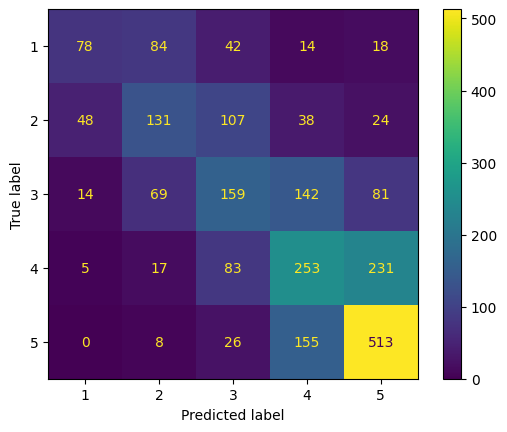

In [655]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

La matriz de confusion mustra que hay una mejora ya que la concentracion en las 3 diagonales del centro en mucho mayor a la matriz anterior

A pesar de que los scores F1 no son tan altos en ninguna de las 2 iteraciones al utilizar Tf-IDF se nota una mejora significativa y el bajo puntaje se puede explicar por la anturaliza multinomial del modelo utilizado. 

## Naive Bayes

Desarrollado por: Maria Castro Iregui

El algoritmo de Naive Bayes es un algoritmo de clasificación que se basa en el uso de probabilidades y el teorema de Bayes para predecir la clasificación en base a sus características. Para el caso de análisis de textos, el algoritmo analiza cada reseña como un conjunto de palabras, el cuál es construido con el algoritmo de BoW (Bag of Words) y calcula la probabilidad de que cada palabra se asocie a una de las calificaciones. Después, multiplica estas probabilidades independientes y este resultado lo multiplica por la probabilidad de que sea de cada una de las clasificaciones posibles. Finalmente, selecciona la clasificación con la probabilidad más alta. Es importante notar que este algoritmo supone todas las palabras entre sí, por lo cual es un algoritmo con alto sesgo (bias) y baja varianza.

### Entrenamiento sin filtro de palabras

In [38]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_bow, y_train)


MultinomialNB()

In [39]:
df_feature_importance = pd.DataFrame(naive_bayes.feature_log_prob_.transpose(), index=bow_vectorizer.get_feature_names_out(), columns=naive_bayes.classes_)

# las probabilidades estan en escala logaritmica, convertir a escala normal
df_feature_importance = df_feature_importance.apply(lambda x: np.exp(x), axis=0)

Se obtienen las 20 palabras más probables en cada clasificación.

In [40]:
df_feature_importance[1].sort_values(ascending=False).head(20)

hotel        0.012084
habit        0.009837
mal          0.006357
com          0.006248
mas          0.006111
si           0.005590
habi         0.005097
servici      0.004521
lleg         0.004357
hac          0.004110
noch         0.003918
sol          0.003918
lug          0.003754
buen         0.003590
teni         0.003425
personal     0.003316
mejor        0.002932
recepcion    0.002905
restaur      0.002850
reserv       0.002795
Name: 1, dtype: float64

In [41]:
df_feature_importance[2].sort_values(ascending=False).head(20)

hotel       0.013320
habit       0.011748
mas         0.007632
com         0.007156
buen        0.006949
si          0.006143
mal         0.006143
servici     0.005460
sol         0.004922
lug         0.004695
hac         0.004364
mejor       0.004343
lleg        0.004323
pued        0.003888
habi        0.003868
bien        0.003847
restaur     0.003475
personal    0.003371
teni        0.003289
esper       0.003206
Name: 2, dtype: float64

In [42]:
df_feature_importance[3].sort_values(ascending=False).head(20)

hotel      0.012032
buen       0.010207
habit      0.009065
mas        0.008512
com        0.007665
si         0.007517
lug        0.005822
bien       0.005546
mejor      0.004883
servici    0.004864
sol        0.004606
hac        0.004459
restaur    0.004330
pued       0.004182
visit      0.004090
haban      0.003869
noch       0.003722
asi        0.003372
desayun    0.003335
vist       0.003335
Name: 3, dtype: float64

In [43]:
df_feature_importance[4].sort_values(ascending=False).head(20)

buen        0.014346
hotel       0.010114
lug         0.007998
com         0.007998
mas         0.006760
si          0.006502
habit       0.006433
bien        0.006313
pued        0.006158
visit       0.005436
servici     0.005160
restaur     0.004902
vist        0.004541
ciud        0.004541
haban       0.004335
hac         0.004128
mejor       0.004094
excelent    0.003939
sol         0.003870
pas         0.003870
Name: 4, dtype: float64

In [44]:
df_feature_importance[5].sort_values(ascending=False).head(20)

buen        0.010379
com         0.010230
excelent    0.008729
lug         0.007871
servici     0.007557
hotel       0.007326
mas         0.006699
visit       0.006221
restaur     0.005990
pued        0.005808
si          0.005412
mejor       0.005264
bien        0.005049
ciud        0.004620
vist        0.004538
habit       0.004422
personal    0.004290
atencion    0.004158
hac         0.004026
pas         0.003911
Name: 5, dtype: float64

In [45]:
y_train_naive_predict = naive_bayes.predict(X_train_bow)
y_test_naive_predict = naive_bayes.predict(bow_vectorizer.transform(X_test))

In [46]:
print('Clases', len(naive_bayes.classes_))
print('Etiquetas:', naive_bayes.classes_)
print('Features:', len(naive_bayes.feature_log_prob_[0]))
print('Features relevantes', np.count_nonzero(naive_bayes.feature_log_prob_))
print('Prior probabilities:', naive_bayes.class_log_prior_)
print('Feature log probabilities:', naive_bayes.feature_log_prob_)

Clases 5
Etiquetas: [1 2 3 4 5]
Features: 12583
Features relevantes 62915
Prior probabilities: [-2.29310289 -1.90533736 -1.6145812  -1.3800843  -1.20482818]
Feature log probabilities: [[ -6.05055585 -10.50490314 -10.50490314 ...  -9.81175596  -9.11860878
  -10.50490314]
 [ -6.11339267 -10.7862215  -10.7862215  ... -10.09307432  -8.70677996
   -9.68760921]
 [ -6.28668005 -10.20865339 -10.90180057 ... -10.90180057  -9.29236266
  -10.90180057]
 [ -6.78088563 -10.97054037 -10.97054037 ... -10.97054037  -9.36110246
  -10.97054037]
 [ -7.18350778  -9.91353689 -10.319002   ... -11.01214918  -9.91353689
  -10.319002  ]]


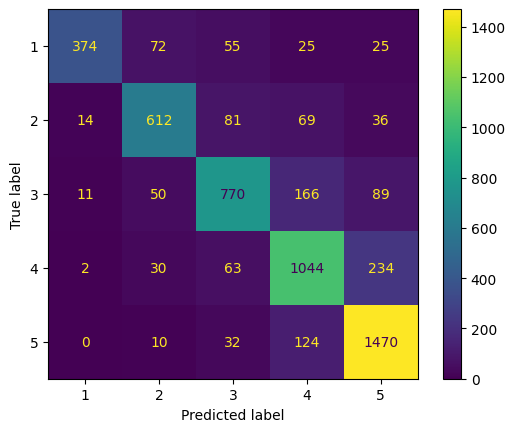

In [47]:
# Matriz de confusión sobre el conjunto de entrenamiento
ConfusionMatrixDisplay.from_predictions(y_train, y_train_naive_predict)

In [48]:
# Metricas para el conjunto de entrenamiento
print("accuracy:", naive_bayes.score(bow_vectorizer.transform(X_train), y_train))
print("precision:", precision_score(y_train, y_train_naive_predict, average='macro'))
print("recall:", recall_score(y_train, y_train_naive_predict, average='macro'))
print("f1:", f1_score(y_train, y_train_naive_predict, average='macro'))

accuracy: 0.7823378526932943
precision: 0.8033138937401795
recall: 0.7600792285207578
f1: 0.7766446695642211


In [49]:
report = classification_report(y_train, y_train_naive_predict)
print(report)

              precision    recall  f1-score   support

           1       0.93      0.68      0.79       551
           2       0.79      0.75      0.77       812
           3       0.77      0.71      0.74      1086
           4       0.73      0.76      0.75      1373
           5       0.79      0.90      0.84      1636

    accuracy                           0.78      5458
   macro avg       0.80      0.76      0.78      5458
weighted avg       0.79      0.78      0.78      5458



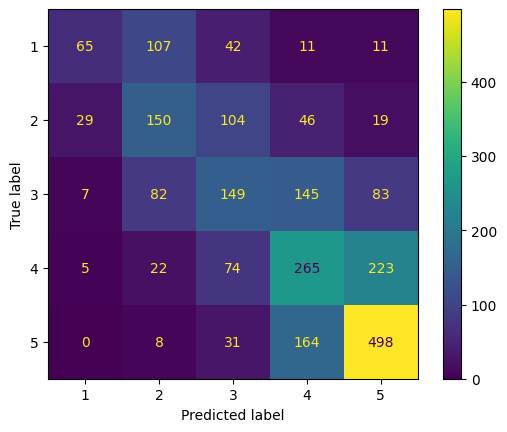

In [50]:
# Matriz de confusión para el conjunto de prueba
ConfusionMatrixDisplay.from_predictions(y_test, y_test_naive_predict)

In [51]:
# Metricas para el conjunto de prueba
print("accuracy:", naive_bayes.score(tfidf_vectorizer.transform(X_test), y_test))
print("precision:", precision_score(y_test, y_test_naive_predict, average='macro'))
print("recall:", recall_score(y_test, y_test_naive_predict, average='macro'))
print("f1:", f1_score(y_test, y_test_naive_predict, average='macro'))

accuracy: 0.45427350427350427
precision: 0.4818604437295315
recall: 0.4373059011841858
f1: 0.4451848039540825


In [52]:
report = classification_report(y_test, y_test_naive_predict)
print(report)

              precision    recall  f1-score   support

           1       0.61      0.28      0.38       236
           2       0.41      0.43      0.42       348
           3       0.37      0.32      0.34       466
           4       0.42      0.45      0.43       589
           5       0.60      0.71      0.65       701

    accuracy                           0.48      2340
   macro avg       0.48      0.44      0.45      2340
weighted avg       0.48      0.48      0.47      2340



Aunque la métricas estan aceptable dadado que es un problema de clasificación multiclase, creemos que es posible mejorarlas. Además se observa que hay overfitting, pues las métricas sobre el conjunto de entrenamiento y el de prueba tienen un nivel de variación significativo. Además podemos ver que las palabras de más alta probabilidad de cada clasificación son dicientes pero hay algunas repeticiones que buscamos eliminar. Por esta razón, se decide user el filtro de palabras de altra frecuencia desarollado durante la etapa de procesamiento para reducir la dimension del problema y buscar obtener mejores métricas. 


### Entrenamiento con filtro de palabras

In [53]:
naive_bayes_filtered = MultinomialNB()
naive_bayes_filtered.fit(X_train_bow_filtered, y_train)

MultinomialNB()

In [54]:
df_feature_importance_filtered= pd.DataFrame(naive_bayes_filtered.feature_log_prob_.transpose(), index=df_palabras_altafrec['Palabra'], columns=naive_bayes_filtered.classes_)

# las probabilidades estan en escala logaritmica, convertir a escala normal
df_feature_importance_filtered = df_feature_importance_filtered.apply(lambda x: np.exp(x), axis=0)

Nuevamente, se obtienen las 20 palabras con más alta probabilidad en cada clasificación.

In [55]:
df_feature_importance_filtered[1].sort_values(ascending=False).head(20)

Palabra
hotel        0.024827
habit        0.020211
mal          0.013061
com          0.012836
mas          0.012554
si           0.011485
habi         0.010471
servici      0.009289
lleg         0.008951
hac          0.008445
noch         0.008050
sol          0.008050
lug          0.007713
buen         0.007375
teni         0.007037
personal     0.006812
mejor        0.006024
recepcion    0.005967
restaur      0.005855
reserv       0.005742
Name: 1, dtype: float64

In [56]:
df_feature_importance_filtered[2].sort_values(ascending=False).head(20)

Palabra
hotel       0.023824
habit       0.021012
mas         0.013650
com         0.012800
buen        0.012430
si          0.010987
mal         0.010987
servici     0.009766
sol         0.008804
lug         0.008397
hac         0.007806
mejor       0.007769
lleg        0.007732
pued        0.006955
habi        0.006918
bien        0.006881
restaur     0.006215
personal    0.006030
teni        0.005882
esper       0.005734
Name: 2, dtype: float64

In [57]:
df_feature_importance_filtered[3].sort_values(ascending=False).head(20)

Palabra
hotel      0.020661
buen       0.017529
habit      0.015567
mas        0.014618
com        0.013162
si         0.012909
lug        0.009998
bien       0.009524
mejor      0.008385
servici    0.008353
sol        0.007910
hac        0.007657
restaur    0.007436
pued       0.007182
visit      0.007024
haban      0.006645
noch       0.006391
asi        0.005790
vist       0.005727
desayun    0.005727
Name: 3, dtype: float64

In [58]:
df_feature_importance_filtered[4].sort_values(ascending=False).head(20)

Palabra
buen        0.023977
hotel       0.016905
com         0.013369
lug         0.013369
mas         0.011299
si          0.010867
habit       0.010752
bien        0.010551
pued        0.010292
visit       0.009085
servici     0.008625
restaur     0.008194
ciud        0.007590
vist        0.007590
haban       0.007245
hac         0.006900
mejor       0.006842
excelent    0.006584
pas         0.006469
sol         0.006469
Name: 4, dtype: float64

In [59]:
df_feature_importance_filtered[5].sort_values(ascending=False).head(20)

Palabra
buen        0.017687
com         0.017434
excelent    0.014875
lug         0.013413
servici     0.012879
hotel       0.012485
mas         0.011416
visit       0.010601
restaur     0.010207
pued        0.009898
si          0.009223
mejor       0.008970
bien        0.008604
ciud        0.007873
vist        0.007733
habit       0.007536
personal    0.007311
atencion    0.007086
hac         0.006861
pas         0.006664
Name: 5, dtype: float64

In [60]:
#  la eliminacion frecuencias bajas en text

# X_test as df
X_test_bow = bow_vectorizer.transform(X_test)
df_X_test_bow = pd.DataFrame(X_test_bow.toarray(),columns=bow_vectorizer.get_feature_names_out())

df_X_test_bow_filtrado = df_X_test_bow[palabras_altafrecuencia]
X_test_bow_filtrado = df_X_test_bow_filtrado.to_numpy()

# Filtrar las columnas que coinciden con las palabras de alta frecuencia

y_test_naive_filtr_predict = naive_bayes_filtered.predict(X_test_bow_filtrado)

y_train_naive_filtr_predict = naive_bayes_filtered.predict(X_train_bow_filtered)

In [61]:
print('Clases', len(naive_bayes_filtered.classes_))
print('Etiquetas:', naive_bayes_filtered.classes_)
print('Features:', len(naive_bayes_filtered.feature_log_prob_[0]))
print('Features relevantes', np.count_nonzero(naive_bayes_filtered.feature_log_prob_))
print('Prior probabilities:', naive_bayes_filtered.class_log_prior_)
print('Feature log probabilities:', naive_bayes_filtered.feature_log_prob_)

Clases 5
Etiquetas: [1 2 3 4 5]
Features: 702
Features relevantes 3510
Prior probabilities: [-2.29310289 -1.90533736 -1.6145812  -1.3800843  -1.20482818]
Feature log probabilities: [[-3.69582805 -4.9096756  -4.35552729 ... -7.07682272 -7.58764834
  -6.60681909]
 [-3.7370779  -4.38766547 -4.35833785 ... -7.0267228  -7.5657193
  -7.5657193 ]
 [-3.87949349 -4.04390593 -4.33038535 ... -8.16384604 -7.87616397
  -8.28162907]
 [-4.08015709 -3.73065064 -4.31484664 ... -8.66512457 -8.15429895
  -8.3774425 ]
 [-4.38323649 -4.03492979 -4.04934157 ... -9.78591387 -8.08116578
  -9.78591387]]


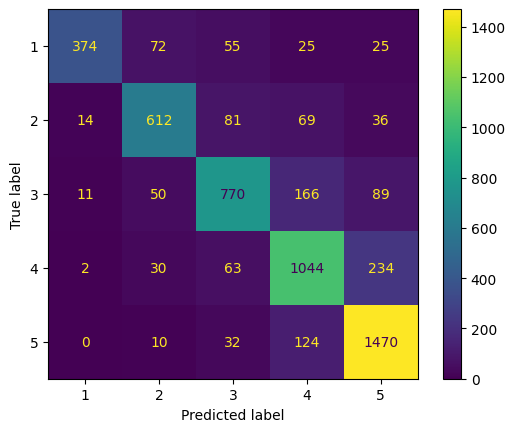

In [62]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_naive_predict)

In [63]:
print("accuracy:", naive_bayes_filtered.score(X_train_bow_filtered, y_train))
print("precision:", precision_score(y_train, y_train_naive_filtr_predict, average='macro'))
print("recall:", recall_score(y_train, y_train_naive_filtr_predict, average='macro'))
print("f1:", f1_score(y_train, y_train_naive_filtr_predict, average='macro'))

accuracy: 0.5694393550751191
precision: 0.5569834602566566
recall: 0.5529355988125927
f1: 0.5513485877669311


In [64]:
report = classification_report(y_train, y_train_naive_filtr_predict)
print(report)

              precision    recall  f1-score   support

           1       0.58      0.62      0.60       551
           2       0.55      0.47      0.50       812
           3       0.52      0.42      0.46      1086
           4       0.51      0.47      0.48      1373
           5       0.64      0.79      0.71      1636

    accuracy                           0.57      5458
   macro avg       0.56      0.55      0.55      5458
weighted avg       0.56      0.57      0.56      5458



In [65]:
print("accuracy:", naive_bayes_filtered.score(X_test_bow_filtrado, y_test))
print("precision:", precision_score(y_test, y_test_naive_filtr_predict, average='macro'))
print("recall:", recall_score(y_test, y_test_naive_filtr_predict, average='macro'))
print("f1:", f1_score(y_test, y_test_naive_filtr_predict, average='macro'))

accuracy: 0.4568376068376068
precision: 0.4290141244805687
recall: 0.43207806510339813
f1: 0.42749607061584183


In [66]:
report = classification_report(y_test, y_test_naive_filtr_predict)
print(report)

              precision    recall  f1-score   support

           1       0.44      0.47      0.46       236
           2       0.38      0.34      0.36       348
           3       0.35      0.27      0.30       466
           4       0.40      0.38      0.39       589
           5       0.57      0.70      0.63       701

    accuracy                           0.46      2340
   macro avg       0.43      0.43      0.43      2340
weighted avg       0.44      0.46      0.45      2340



A partir de las métricas y las palabras asigandas a cada clasficiación notamos que aunque en el conjunto de entrenamiento las métricas se reducen significativamente, vemos que hay menos overfitting en cuanto al conjunto de prueba. Sin embargo, el f1-score en esta iteración es menor al del modelo sin realizar el ajuste de la frecuencia de palabras. En cuanto a las palabras, vemos un conjutno para cada clasificación un poco más diciente en cuanto a los objetivos del negocio.

### Conclusiones

A pesar de que los f1-scores en ambas iteraciones son bajos, se debe tener en cuenta el 'trade-off' entre un mejor f1-score y un conjutno de features un poco más diciente para el negocio. Como el objetivo mencionado es obtener un alto nivel de precisión y de sensibilidad (recall), se le recomendaria al negocio irse por la primera iteración de Naive Bayes. Sin embargo, se debe tener en cuenta los resultados de todos los modelos antes de hacer una recomendación final.